In [30]:
from collections import defaultdict
import itertools
import os
from pathlib import Path
import random
import time

from IPython.display import clear_output

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import numpy as np
from scipy.interpolate import interp1d
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import math

In [2]:
# tf.config.run_functions_eagerly(True)

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
def preprocess_images(images):
    return images.astype("float32") / 255.

X_train = preprocess_images(X_train)
X_test = preprocess_images(X_test)

In [5]:
train_size = len(X_train)
batch_size = 32
test_size = len(X_test)

In [6]:
print(X_train.shape, y_train.shape)
print(tf.reduce_min(X_train))
print(tf.reduce_max(X_train))
print(tf.reduce_min(y_train))
print(tf.reduce_max(y_train))

(50000, 32, 32, 3) (50000, 1)


2022-09-29 21:10:14.656290: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 21:10:15.123302: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22309 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0, shape=(), dtype=uint8)
tf.Tensor(9, shape=(), dtype=uint8)


In [7]:
train_dataset = (tf.data.Dataset.from_tensor_slices(X_train)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(X_test)
                .shuffle(test_size).batch(batch_size))

In [9]:
def base_log_dir():
    return os.path.join(os.curdir, ".tflogs", "variational_autoencoder")

def get_tensorboard_cb(callback=keras.callbacks.TensorBoard):
    base_dir = base_log_dir()
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    run_dir = os.path.join(base_dir, run_id)
    return callback(run_dir)

In [10]:
class ModelSnapshotter(keras.callbacks.Callback):
    def __init__(self, frequency):
        super().__init__()
        self.frequency = frequency
        self.weights = []
    
    def on_epoch_end(self, epoch, logs):
        if epoch % self.frequency == 0:
            self.weights.append(self.model.get_weights())

In [12]:
# adapted from https://www.tensorflow.org/tutorials/generative/cvae#network_architecture
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""
    def __init__(self, latent_dim, gaussian_reconstruction=False, gaussian_reconstruction_variance=0.01):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.gaussian_reconstruction = gaussian_reconstruction
        self.log_gaussian_reconstruction_variance = tf.math.log(gaussian_reconstruction_variance)
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu', padding="same"),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding="same"),
                tf.keras.layers.Conv2D(
                    filters=128, kernel_size=3, strides=(2, 2), activation='relu', padding="same"),
                tf.keras.layers.Conv2D(
                    filters=256, kernel_size=3, strides=(2, 2), activation='relu', padding="same"),
                tf.keras.layers.Conv2D(
                    filters=512, kernel_size=3, strides=(2, 2), activation='relu', padding="same"),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )
        
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(1, 1, 512)),
                tf.keras.layers.Conv2DTranspose(
                    filters=256, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=128, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=3, kernel_size=3, strides=2, padding='same'),
            ]
        )
    
    @tf.function
    def sample(self, eps=None, n_samples=10):
        if eps is None:
            eps = tf.random.normal(shape=(n_samples, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)
    
    def compute_loss(self, x, y=None, y_pred=None, sample_weight=None):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        if self.gaussian_reconstruction:
            x_pred = self.decode(z, apply_sigmoid=True)
            logpx_z = self.log_normal_pdf(x_pred, x, self.log_gaussian_reconstruction_variance, raxis=[1, 2, 3])
        else:
            x_logit = self.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)
        return -tf.reduce_mean(logpx_z + logpz - logqz_x)
    
    def train_step(self, x):
        """Executes one training step and returns the loss.
        
        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}
    
    def test_step(self, x):
        return {"loss": self.compute_loss(x)}
    
    
    def call(self, inputs, training=None, mask=None):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z, apply_sigmoid=True)

In [13]:
crossentropy_history = ModelSnapshotter(5)
crossentropy_cvae = CVAE(30)
crossentropy_cvae.compile(optimizer="adam")
crossentropy_cvae.fit(
    train_dataset, 
    validation_data=test_dataset,
    epochs=50,
    callbacks=[
        get_tensorboard_cb(), 
        crossentropy_history,
        # keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ])

Epoch 1/50


2022-09-29 21:10:20.991931: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-09-29 21:10:21.583704: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-29 21:10:21.584855: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-29 21:10:21.584892: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-29 21:10:21.586072: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-29 21:10:21.586214: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-09-29 21:10:22.134490: I tensorflow/stream_executor/cuda/c

1563/1563 [==============================] - 23s 13ms/step - loss: 1924.3058 - val_loss: 1847.2478
Epoch 2/50
1563/1563 [==============================] - 20s 13ms/step - loss: 1866.9092 - val_loss: 1934.4907
Epoch 3/50
1563/1563 [==============================] - 20s 13ms/step - loss: 1856.2439 - val_loss: 1908.0293
Epoch 4/50
1563/1563 [==============================] - 20s 13ms/step - loss: 1852.2098 - val_loss: 1795.7668
Epoch 5/50
1563/1563 [==============================] - 20s 13ms/step - loss: 1849.0431 - val_loss: 1771.7639
Epoch 6/50
1563/1563 [==============================] - 20s 13ms/step - loss: 1847.1362 - val_loss: 1850.0613
Epoch 7/50
1563/1563 [==============================] - 20s 13ms/step - loss: 1845.0521 - val_loss: 1890.2065
Epoch 8/50
1563/1563 [==============================] - 20s 13ms/step - loss: 1843.3468 - val_loss: 1818.5981
Epoch 9/50
1563/1563 [==============================] - 20s 13ms/step - loss: 1841.5877 - val_loss: 1849.1824
Epoch 10/50
1563/1563

In [14]:
def display_samples(samples):
    n = len(samples)
    c = 10
    r = n // c
    fig, axs = plt.subplots(r, c, figsize=(20, 20))
    for i in range(samples.shape[0]):
        ri = i // c
        ci = i % c
        axs[ri, ci].imshow(samples[i])

In [17]:
gaussian_history = ModelSnapshotter(5)
gaussian_cvae = CVAE(30, gaussian_reconstruction=True)
gaussian_cvae.compile(optimizer="adam")
gaussian_cvae.fit(
    train_dataset, 
    validation_data=test_dataset,
    epochs=50,
    callbacks=[
        get_tensorboard_cb(), 
        gaussian_history,
        # keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ])

Epoch 1/50
1563/1563 [==============================] - 21s 13ms/step - loss: 143.3158 - val_loss: -1672.6440
Epoch 2/50
1563/1563 [==============================] - 20s 13ms/step - loss: -1459.2494 - val_loss: -2046.0685
Epoch 3/50
1563/1563 [==============================] - 20s 13ms/step - loss: -1783.9113 - val_loss: -2171.9307
Epoch 4/50
1563/1563 [==============================] - 20s 13ms/step - loss: -1973.4809 - val_loss: -1558.3850
Epoch 5/50
1563/1563 [==============================] - 20s 13ms/step - loss: -2084.4458 - val_loss: -2289.7979
Epoch 6/50
1563/1563 [==============================] - 20s 13ms/step - loss: -2185.3827 - val_loss: -2832.5918
Epoch 7/50
1563/1563 [==============================] - 20s 13ms/step - loss: -2244.6844 - val_loss: -2113.6687
Epoch 8/50
1563/1563 [==============================] - 20s 13ms/step - loss: -2270.0461 - val_loss: -2368.2720
Epoch 9/50
1563/1563 [==============================] - 20s 13ms/step - loss: -2286.1672 - val_loss: -1946

### Unconditional Samples

Across rows 1-10, samples are drawn from model weights captured at epoch 5, 10, ..., 45, 50.

Pairs of images across columns 1-10: samples from crossentropy loss are odd indices, samples from gaussian loss are even. Gaussian samples are of higher quality.

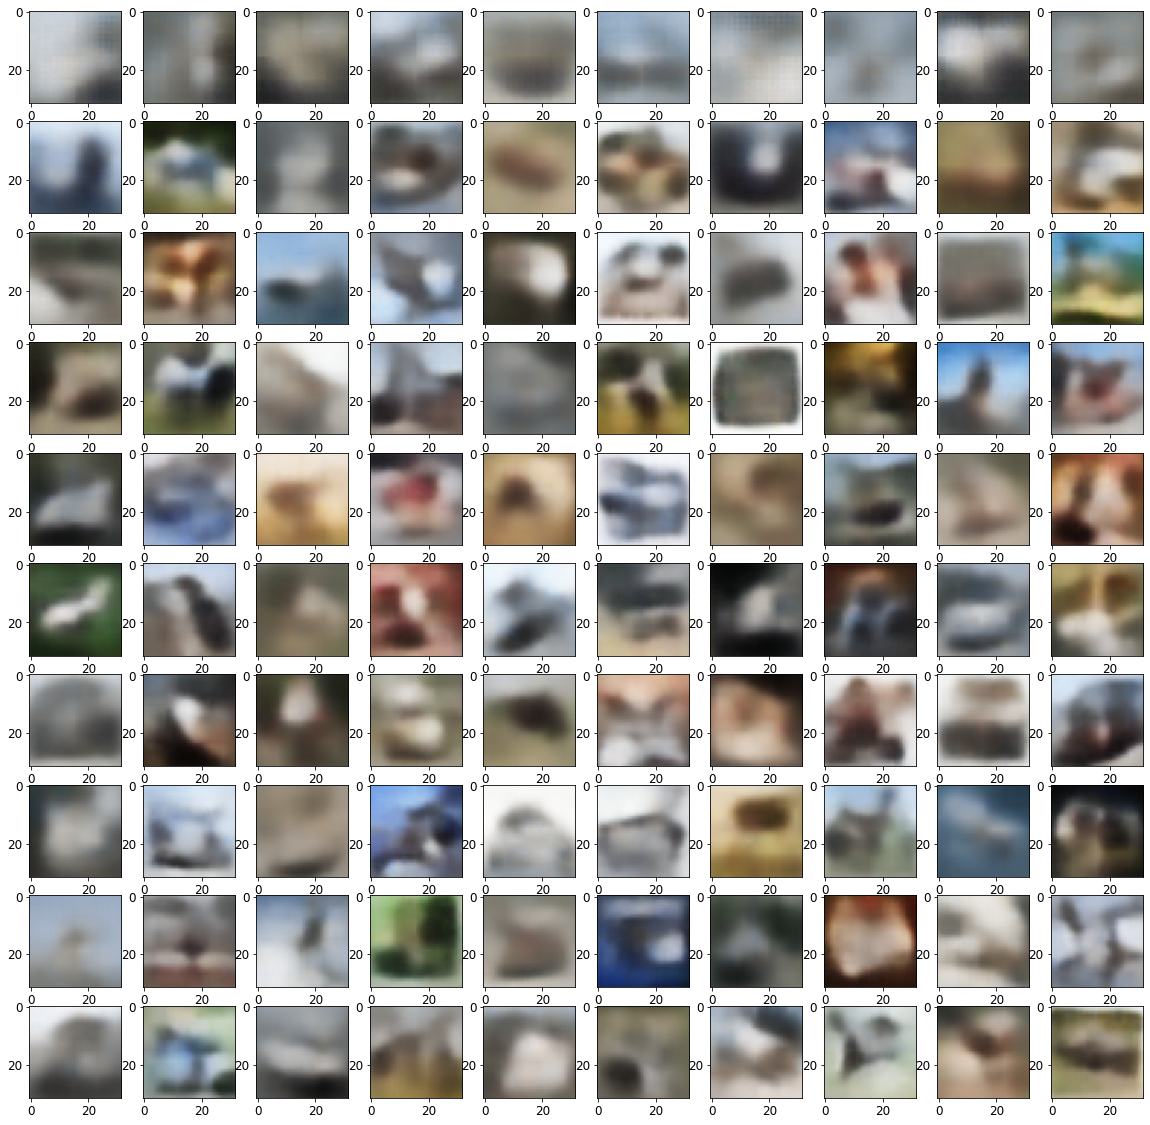

In [28]:
samples = []
for weights in crossentropy_history.weights:
    crossentropy_cvae.set_weights(weights)
    samples.append(crossentropy_cvae.sample(n_samples=5))

crossentropy_samples = tf.concat(samples, 0)

samples = []
for weights in gaussian_history.weights:
    gaussian_cvae.set_weights(weights)
    samples.append(gaussian_cvae.sample(n_samples=5))

gaussian_samples = tf.concat(samples, 0)

stacked = tf.stack([crossentropy_samples, gaussian_samples], axis=1)
reshaped = tf.reshape(stacked, [-1, 32, 32, 3])

display_samples(reshaped)

### Reconstructions

Pairs of images across columns 1-10: reconstructions from crossentropy loss are odd indices, reconstructions from gaussian loss are even. Gaussian reconstructions are of higher quality, but still very noisy.

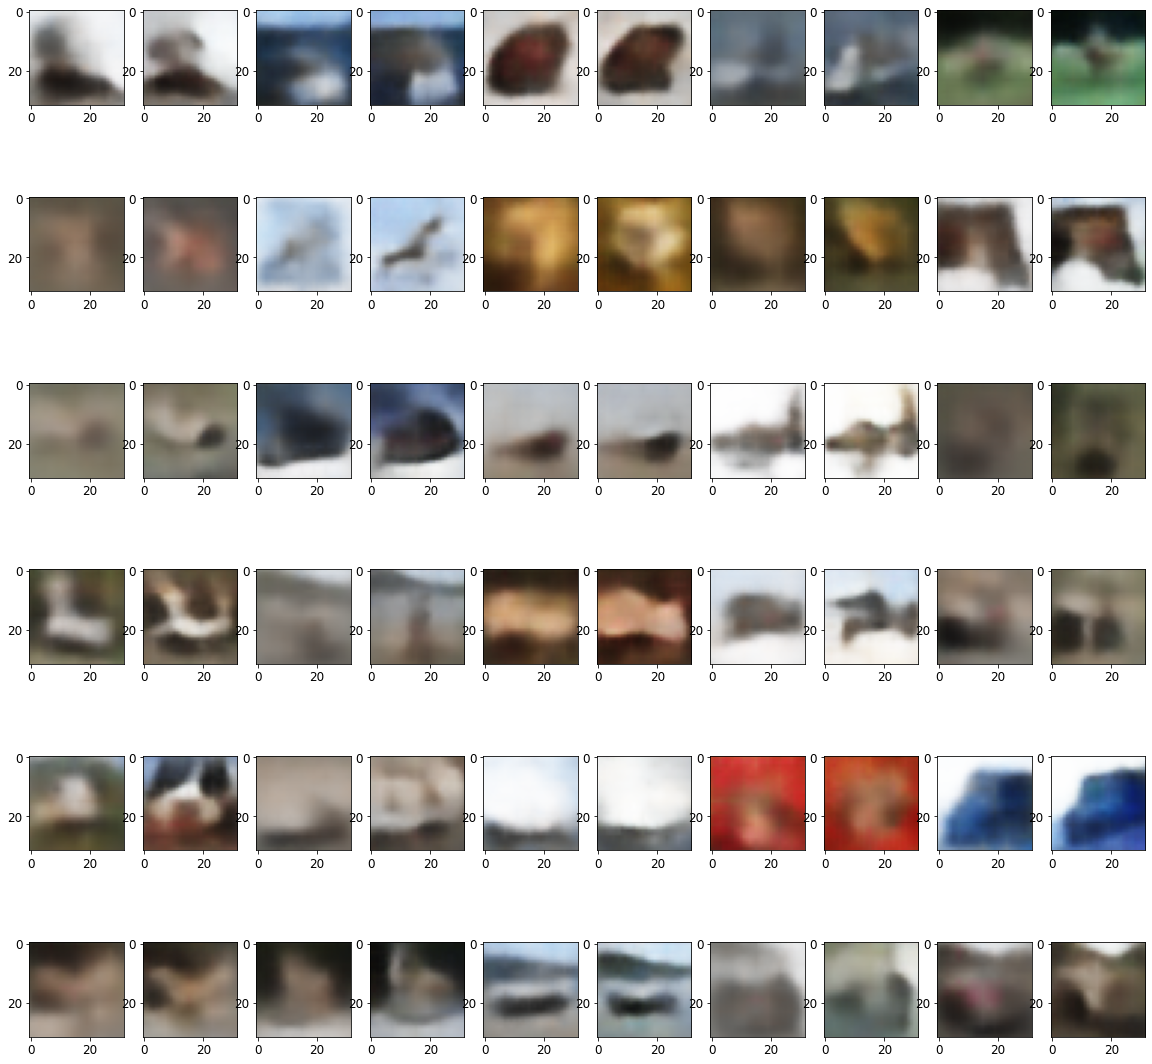

In [26]:
dataset_sample = next(iter(test_dataset.unbatch().batch(30).take(1)))
crossentropy_conditional_samples = crossentropy_cvae(dataset_sample)
gaussian_conditional_samples = gaussian_cvae(dataset_sample)
stacked = tf.stack([crossentropy_conditional_samples, gaussian_conditional_samples], axis=1)
reshaped = tf.reshape(stacked, [-1, 32, 32, 3])
display_samples(reshaped)

### Latent Linear Interpolation

In [59]:
def interpolate(samples, per_interpolation=8):
    sample_range = list(range(len(samples)))
    range_end = sample_range[-1]
    linfit = interp1d(sample_range, samples, axis=0)
    return linfit(np.linspace(0, range_end, per_interpolation*range_end))

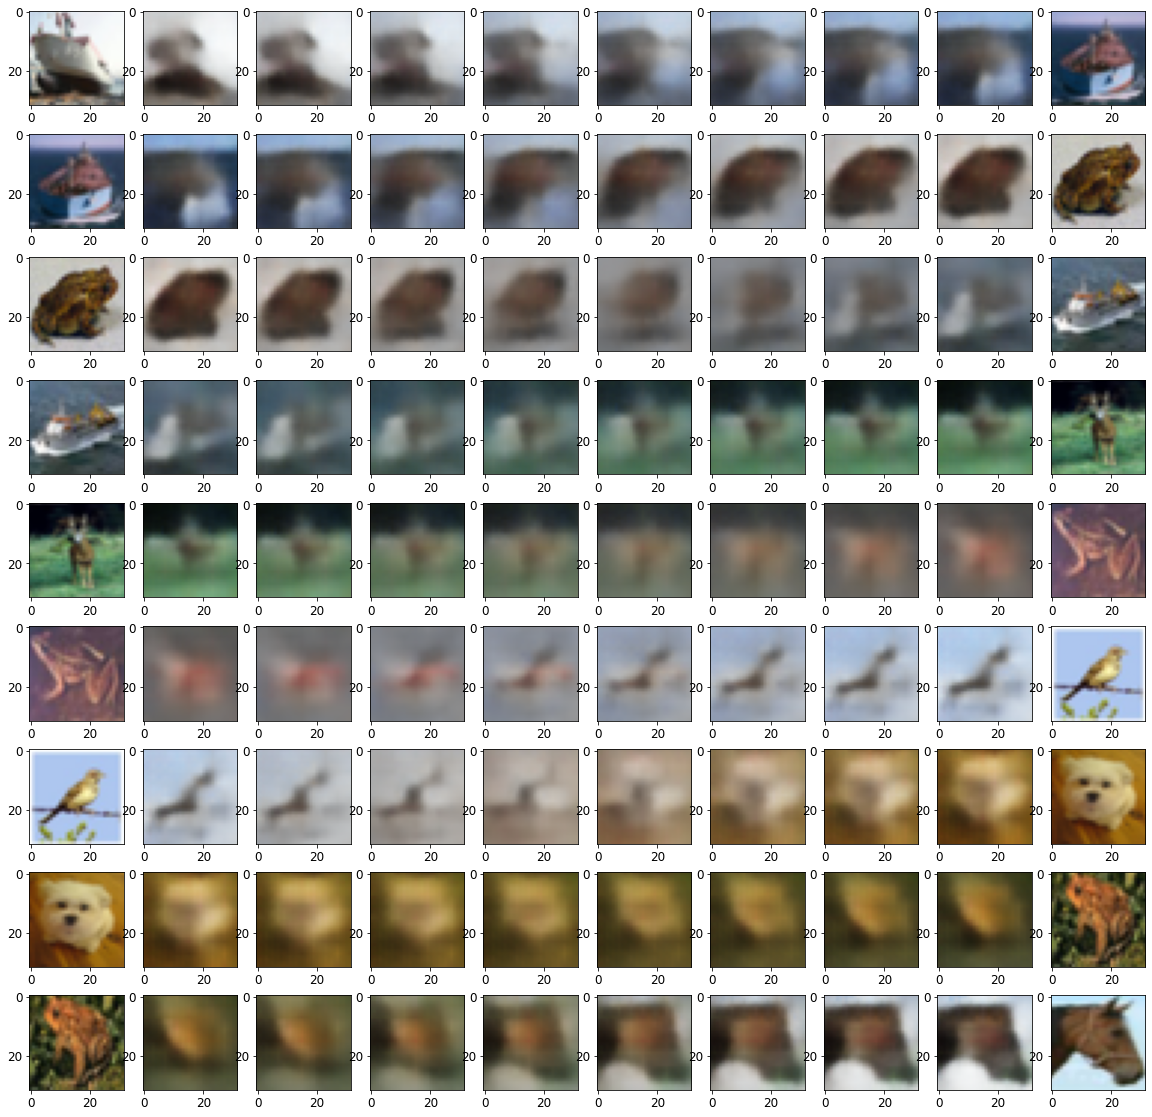

In [60]:
per_interpolation = 8

x_samples = dataset_sample[:10].numpy()
z_means, z_logvars = gaussian_cvae.encode(x_samples)
z_samples = gaussian_cvae.reparameterize(z_means, z_logvars)
z_interpolated = interpolate(z_samples, per_interpolation=per_interpolation)
x_reconstructions = gaussian_cvae.decode(z_interpolated, apply_sigmoid=True)

x_pieces = []
for i in range(1, len(x_samples)):
    x_pieces.append(x_samples[i-1:i])
    x_pieces.append(x_reconstructions[(i-1)*per_interpolation:i*per_interpolation])
    x_pieces.append(x_samples[i:i+1])
    
output_samples = tf.concat(x_pieces, axis=0)
display_samples(output_samples)